In [1]:
!pip install --upgrade numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 32.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.4 which is incompatible.


In [2]:
 pip install git+https://github.com/mimoralea/gym-walk#egg=gym-walk

  Cloning https://github.com/mimoralea/gym-walk to /tmp/pip-install-g53s7j51/gym-walk_3c35c999fd1a4f47aa51031310d1ede7
  Running command git clone --filter=blob:none --quiet https://github.com/mimoralea/gym-walk /tmp/pip-install-g53s7j51/gym-walk_3c35c999fd1a4f47aa51031310d1ede7
  Resolved https://github.com/mimoralea/gym-walk to commit b915b94cf2ad16f8833a1ad92ea94e88159279f5
  Preparing metadata (setup.py) ... done
  Created wheel for gym-walk: filename=gym_walk-0.0.2-py3-none-any.whl size=5377 sha256=5ca3c940c92353c693358a5da13d92a71ba6ed852724a7fa6a6b110b62b914a0
  Stored in directory: /tmp/pip-ephem-wheel-cache-f2kn80xj/wheels/60/02/77/2dd9f31df8d13bc7c014725f4002e29d0fc3ced5e8ac08e1cf
Successfully built gym-walk


In [3]:
def print_state_value_function(V, P, n_cols=4, prec=3, title='State-value function:'):
    print(title)
    for s in range(len(P)):
        v = V[s]
        print("| ", end="")
        if np.all([done for action in P[s].values() for _, _, _, done in action]):
            print("".rjust(9), end=" ")
        else:
            print(str(s).zfill(2), '{}'.format(np.round(v, prec)).rjust(6), end=" ")
        if (s + 1) % n_cols == 0: print("|")

In [4]:
import warnings ; warnings.filterwarnings('ignore')

import gym, gym_walk
import numpy as np

import random
import warnings

warnings.filterwarnings('ignore', category=DeprecationWarning)
np.set_printoptions(suppress=True)
random.seed(123); np.random.seed(123)

In [5]:
env = gym.make('FrozenLake-v1')
P = env.env.P
init_state = env.reset()
goal_state = 15

In [6]:
def decay_schedule(
    init_value, min_value, decay_ratio,
    max_steps, log_start = -2, log_base=10):

    decay_steps = int(max_steps * decay_ratio)
    rem_steps = max_steps - decay_steps

    values = np.logspace(
        log_start, 0, decay_steps,
        base=log_base, endpoint=True)[::-1]

    values = (values - values.min()) / (values.max() - values.min())
    values = (init_value - min_value) * values + min_value
    values = np.pad(values, (0, rem_steps), 'edge')
    return values

In [7]:
from itertools import count
import numpy as np
from tqdm import tqdm

In [8]:
def generate_trajectory(
    select_action, Q, epsilon,
    env, max_steps=200):
  done, trajectory = False, []

  while not done:
        state = env.reset()
        for t in count():
            action = select_action(state, Q, epsilon)

            next_state, reward, done, _ = env.step(action)

            experience = (state, action, reward, next_state, done)
            trajectory.append(experience)
            if done:
                break
            if t >= max_steps - 1:
                trajectory = []
                break
            state = next_state
  return np.array(trajectory,object)

In [9]:
def mc_control(env,
               gamma=1.0,
               init_alpha=0.5,
               min_alpha=0.01,
               alpha_decay_ratio=0.5,
               init_epsilon=1.0,
               min_epsilon=0.1,
               epsilon_decay_ratio=0.9,
               n_episodes=3000,
               max_steps=200,
               first_visit=True):

    nS, nA = env.observation_space.n, env.action_space.n

    discounts = np.logspace(
        0, max_steps,
        num=max_steps, base=gamma,
        endpoint=False)

    alphas = decay_schedule(
        init_alpha, min_alpha,
        alpha_decay_ratio,
        n_episodes)

    epsilons = decay_schedule(
        init_epsilon, min_epsilon,
        epsilon_decay_ratio,
        n_episodes)

    pi_track = []
    Q = np.zeros((nS, nA), dtype=np.float64)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=np.float64)

    select_action = lambda state, Q, epsilon:np.argmax(Q[state]) if np.random.random() > epsilon else np.random.randint(len(Q[state]))

    for e in tqdm(range(n_episodes), leave=False):
        trajectory = generate_trajectory(select_action, Q, epsilons[e], env, max_steps)
        visited = np.zeros((nS, nA), dtype=bool)

        for t, (state, action, reward, _, _) in enumerate(trajectory):
            if visited[state][action] and first_visit:
                continue
            visited[state][action] = True

            n_steps = len(trajectory[t:])
            G = np.sum(discounts[:n_steps] * trajectory[t:, 2])
            Q[state][action] = Q[state][action] + alphas[e] * (G - Q[state][action])

        Q_track[e] = Q
        pi_track.append(np.argmax(Q, axis=1))

    v = np.max(Q, axis=1)
    pi = np.argmax(Q, axis=1)
    return Q, v, pi, Q_track, pi_track

In [11]:
# Store the results of mc_control into separate variables
optimal_results = mc_control(env, n_episodes=3000)
optimal_Q, optimal_V, optimal_pi, _, _ = optimal_results  # Unpack the results

print("Thiyagarajan A      212222240110")
# Pass the correct variables to the print functions
print_state_value_function(optimal_V, P, n_cols=4, prec=2, title='State-value function:')


Thiyagarajan A      212222240110
State-value function:
| 00   0.04 | 01   0.06 | 02    0.1 | 03   0.11 |
| 04   0.02 |           | 06   0.12 |           |
| 08   0.04 | 09   0.11 | 10   0.29 |           |
|           | 13   0.21 | 14   0.64 |           |


In [13]:
def value_iteration(P, gamma=1.0, theta=1e-10):
    V = np.zeros(len(P), dtype=np.float64)
    while True:
        Q = np.zeros((len(P), len(P[0])), dtype=np.float64)
        for s in range(len(P)):
            for a in range(len(P[s])):
                for prob, next_state, reward, done in P[s][a]:
                    Q[s][a] += prob * (reward+gamma*V[next_state]*(not done))
        if np.max(np.abs(V-np.max(Q, axis=1))) < theta:
            break
        V = np.max(Q, axis=1)
    pi= lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]

    return V, pi


In [14]:
V_best_v, pi_best_v = value_iteration(P, gamma=0.99)

In [15]:
print("Thiyagarajan A      212222240110")
print_state_value_function(V_best_v, P, prec=4)

Thiyagarajan A      212222240110
State-value function:
| 00  0.542 | 01 0.4988 | 02 0.4707 | 03 0.4569 |
| 04 0.5585 |           | 06 0.3583 |           |
| 08 0.5918 | 09 0.6431 | 10 0.6152 |           |
|           | 13 0.7417 | 14 0.8628 |           |


In [16]:
def compare_value_functions(mc_v, dp_v, P, n_cols=4, prec=4):
    print("\nComparison of State-Value Functions (MC vs Value Iteration):")
    print("=" * 60)
    print(f"{'State':<6} | {'MC Value':<10} | {'Value Iteration':<16}")
    print("-" * 60)
    for s in range(len(P)):
        if np.all([done for action in P[s].values() for _, _, _, done in action]):
            continue  # Skip terminal states
        mc_val = round(mc_v[s], prec)
        dp_val = round(dp_v[s], prec)
        print(f"{s:<6} | {mc_val:<10} | {dp_val:<16}")
    print("=" * 60)

# Call the comparison function
compare_value_functions(optimal_V, V_best_v, P)



Comparison of State-Value Functions (MC vs Value Iteration):
State  | MC Value   | Value Iteration 
------------------------------------------------------------
0      | 0.0377     | 0.542           
1      | 0.0578     | 0.4988          
2      | 0.1049     | 0.4707          
3      | 0.1108     | 0.4569          
4      | 0.0216     | 0.5585          
6      | 0.1228     | 0.3583          
8      | 0.0392     | 0.5918          
9      | 0.1146     | 0.6431          
10     | 0.2871     | 0.6152          
13     | 0.2091     | 0.7417          
14     | 0.6438     | 0.8628          


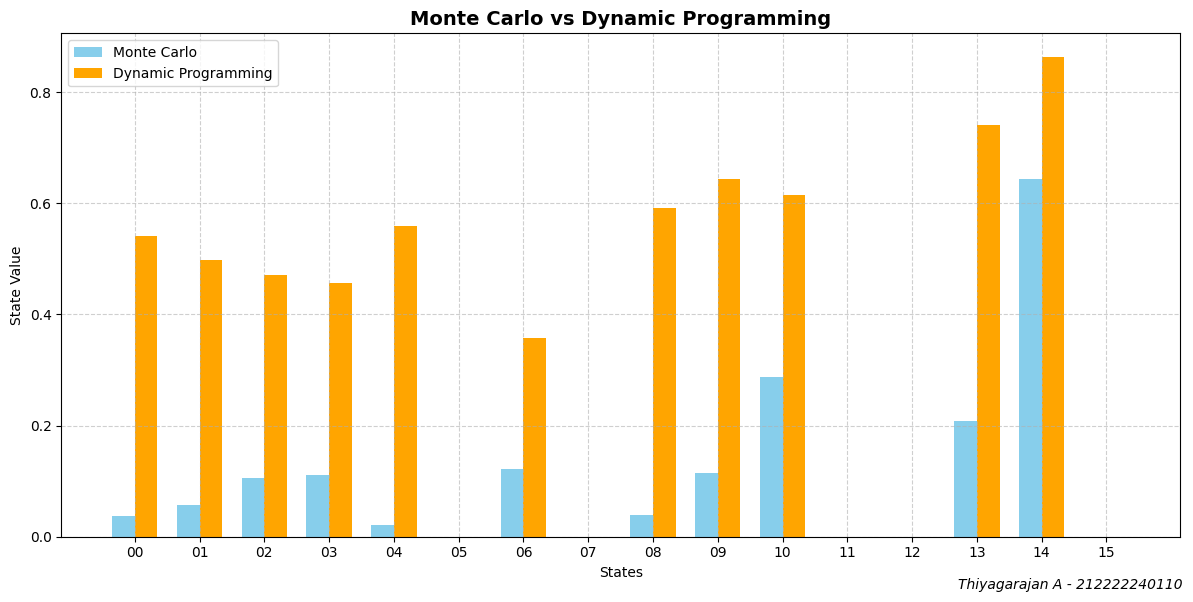

In [18]:
import matplotlib.pyplot as plt
import numpy as np

def plot_value_comparison(mc_v, dp_v, name="Thiyagarajan A", reg_no="212222240110"):
    states = np.arange(len(mc_v))
    width = 0.35  # Width of bars

    fig, ax = plt.subplots(figsize=(12, 6))

    # Plotting both values
    ax.bar(states - width/2, mc_v, width, label='Monte Carlo', color='skyblue')
    ax.bar(states + width/2, dp_v, width, label='Dynamic Programming', color='orange')

    ax.set_xlabel('States')
    ax.set_ylabel('State Value')
    ax.set_title('Monte Carlo vs Dynamic Programming', fontsize=14, fontweight='bold')
    ax.set_xticks(states)
    ax.set_xticklabels([str(s).zfill(2) for s in states])
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)

    # Add footer with name and reg number
    plt.figtext(0.99, 0.01, f'{name} - {reg_no}', horizontalalignment='right', fontsize=10, style='italic')

    plt.tight_layout()
    plt.show()

# Call with your values
plot_value_comparison(optimal_V, V_best_v)
